In [1]:
import numpy as np
import torch
from torch import nn
import time
import matplotlib.pyplot as plt
from ukf  import *
from utils import *
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
overall_path = 'C:/Users/user/project/generate_ev_data/data/overall_pd.csv'
trip_path = 'C:/Users/user/project/generate_ev_data/data/trip_pd.csv'

In [3]:
model = ANN(layers=[3, 4, 8, 16, 8, 4, 1], activation='relu')

checkpoint = torch.load('initial_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint['loss']

In [4]:
v0_model = deepcopy(model)

v_nums = [0]

loss_hist = [[], [], [], []]

v0_model.eval()
model.eval()

for route_num in range(1, 100):
    routes = [route_num]
    ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
    train_loader = DataLoader(ev_dataset, batch_size=512, shuffle=False)

    l_0, l_1 = 0, 0
    for inp, tar in train_loader:
        output_ = model(inp)
        
        i_loss = loss(output_, tar)
        l_0 += i_loss.item()

        output_0 = v0_model(inp)
        v0_loss = loss(output_0, tar)
        l_1 += v0_loss.item()
    l_0 /= len(train_loader)
    l_1 /= len(train_loader)
        
    loss_hist[0].append(route_num)
    loss_hist[1].append(l_0)
    loss_hist[2].append(l_1)

    if l_1 > 0.05:
        # st = time.time()
        print(f'model update at route number {route_num}, ', end=' ')
        loss_hist[3].append(route_num)

        v0_model, ukf = train_ukf(model = v0_model, epoch = 40, loader = train_loader, ukf_params=[1,2,0], log_dir='runs/' + str(route_num))
        print('Update complete')
        # print(time.time() - st)
        l_1 = 0
        for inp, tar in train_loader:
            output = v0_model(inp)
            v0_loss = loss(output, tar)
            l_1 += v0_loss.item()
        l_1 /= len(train_loader)

        loss_hist[2][-1] = l_1


print(f'model updated {len(loss_hist[3])} times after initial model')

model update at route number 14,  ..........Update complete
model update at route number 17,  ..........Update complete
model update at route number 25,  ..........Update complete
model update at route number 31,  ..........Update complete
model update at route number 38,  ..........Update complete
model update at route number 39,  ..........Update complete
model update at route number 40,  ..........Update complete
model update at route number 41,  ..........Update complete
model update at route number 43,  ..........Update complete
model update at route number 45,  ..........Update complete
model update at route number 55,  ..........Update complete
model update at route number 61,  ..........Update complete
model update at route number 63,  ..........Update complete
model update at route number 64,  ..........Update complete
model update at route number 71,  ..........Update complete
model update at route number 72,  ..........Update complete
model update at route number 76,  ......

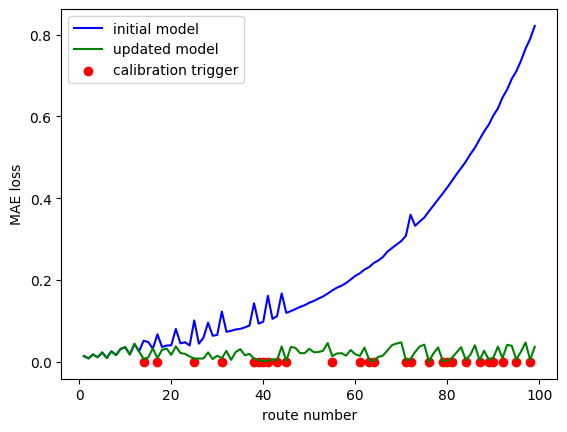

In [6]:
plt.plot(loss_hist[0], loss_hist[1], label = 'initial model', c='b')
plt.plot(loss_hist[0], loss_hist[2], label = 'updated model', c='g')
plt.scatter(loss_hist[3], [0 for _ in loss_hist[3]], label = 'calibration trigger', c='r')
plt.legend()
plt.xlabel('route number')
plt.ylabel('MAE loss')
plt.savefig('retrain_loss_plot.png')
plt.show()

torch.save({
    'epoch' : 100,
    'model_state_dict' : v0_model.state_dict(),
    'optimizer_state_dict' : None,
    'loss' : loss
}, 'retrained_model.pt')